# Pre-bootcamp exercises: accessing data products via butler


- Last Update : 2024/01/13
- w_2023_44

**Description:** Demonstrate how to generate science performance diagnostic plots and metrics with the [analysis_tools](https://github.com/lsst/analysis_tools) package using a small test dataset from HSC, [rc2_subset](https://github.com/lsst/rc2_subset).

**Contact authors:** Keith Bechtol, Nate Lust

**Last verified to run:** 2023-05-18

**LSST Science Piplines version:** w_2023_20

**Container Size:** Medium (or larger)

**Location:** This notebook points to files on the S3DF cluster at the USDF. Update paths accordingly if you are running elsewhere.

**Skills:** 
- Load source and object tables using the Butler.
- Generate a science performance diagnostic plot and corresponding metric values interactively in a notebook and as part of a pipeline (simple pipeline executor). 
- Adjust the configuration used to produce these diagnostics. 
- Retrieve persisted plots and metrics with the Bulter. 
- Reconstitute input data products that were used to create plots and metrics for further investigation.


For a quicker introduction, use an existing sandbox repo (prepared for this exercise) to bypass data reduction steps and go straight to data access via the Butler. If you want the full experience, run the data reduction steps in `process_rc2_subset.sh` and then point the Butler to your own repo.

## Preliminaries

In [1]:
# Basic imports
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from pprint import pprint

If using your personal rc2_subset repo, set `SANDBOX_REPO = False`

In [2]:
SANDBOX_REPO = False

### Getting set up at USDF

The USDF is hosted on the S3DF cluster at SLAC. This notebook has been verified to run on the S3DF cluster.

See USDF documentation at
* https://developer.lsst.io/usdf/lsst-login.html
* https://developer.lsst.io/usdf/onboarding.html

### Processing rc2_subset

[rc2_subset](https://github.com/lsst-dm/rc2_subset) is a small dataset with just enough Hyper Suprime-Cam (HSC) exposures to compute a set of meaningful science performance metrics.

The LSST Science Pipelines [Getting Started tutorial](https://pipelines.lsst.io/#getting-started) provides a guided tour of data processing using rc2_subset as an example.

For convenience, there is a shell script `process_rc2_subset.sh` in the same directory as this notebook that shows the commands to process rc2_subset on the USDF.

### Setting up the analysis_tools package

Check the version of the stack you are using

In [3]:
!eups list -s | grep lsst_distrib

lsst_distrib          g4213664e8e+d053631def 	current w_2023_44 setup


The `analysis_tools` package was added to `lsst_distrib` in August 2022, and accordingly, if you have set up the LSST Stack version `w_2022_32` or later, then you should be able to import `analysis_tools` directly in the notebook.

See the header for this notebook for the most recent verified Science Pipelines version for this tutorial.

In [4]:
import lsst.analysis.tools
print(lsst.analysis.tools.__file__)

/home/d/dagoret/repos/repos_w_2023_44/analysis_tools/python/lsst/analysis/tools/__init__.py


**Additional background information:** If you are doing development on the `analysis_tools` package and want to test in a notebook, follow the guidance [here](https://nb.lsst.io/science-pipelines/development-tutorial.html). Brief version below (for work on the RSP at USDF):

1. In the termal, clone the [analysis_tools](https://github.com/lsst/analysis_tools) repo and set up the package

```
source /opt/lsst/software/stack/loadLSST.bash
setup lsst_distrib

# Choose file location for your repo
cd ~/repos/
git clone https://github.com/lsst/analysis_tools.git
cd analysis_tools
setup -k -r .
scons
```

2. Add the following line to `~/notebooks/.user_setups`

```
setup -k -r ~/repos/analysis_tools
```

Your local version of `analysis_tools` should now be accessible in a notebook.

## Load data for testing

In [5]:
import lsst.daf.butler as dafButler

Point to a shared sandbox instance of the processed rc2_subset or point to your own instance. 

**Note:** For one of the sections later in the notebook that shows how to run analysis_tools as part of a pipeline, you need to point to your own processed instance of rc2_subset. That section can be skipped if you are pointing to the shared sandbox repo.

In [6]:
if SANDBOX_REPO:
    # Point to existing sandbox repo if you prefer to skip processing steps
    collections = ['u/bechtol']
    repo = '/sdf/group/rubin/user/bechtol/bootcamp_2023/rc2_subset/SMALL_HSC/'
else:
    # User instance of the repo if you have processed rc2_subset yourself
    #collections = ['u/%s'%os.environ['USER']]
    #repo = '/sdf/group/rubin/user/%s/bootcamp_2023/rc2_subset/SMALL_HSC/'%(os.environ['USER'])
    repo = "/sdf/group/rubin/repo/oga/"
    collections = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
print(collections)
print(repo)

LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553
/sdf/group/rubin/repo/oga/


In [7]:
butler = dafButler.Butler(repo, collections=collections)
registry = butler.registry

Check what dataset types are present in the collection. Note that the cell below will show _only the dataset types that are present in the specified collection_, not all of the possible dataset types that are known to the butler registry.

In [8]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collections).any(execute=False, exact=False):
        print(datasetType)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
DatasetType('skyMap', {skymap}, SkyMap)
DatasetType('atlas_refcat2_20220201', {htm7}, SimpleCatalog)
DatasetType('packages', {}, Packages)
DatasetType('isr_config', {}, Config)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, TaskMetadata)
DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords)
DatasetType('icSrc_schema', {}, SourceCatalog)
DatasetType('src_schema', {}, SourceCatalog)
Data

### Object tables

The examples below use an object table

In [9]:
refs = sorted(registry.queryDatasets("objectTable_tract"))
print(len(refs))

12


In [10]:
N = len(refs)
for idx in range(N):
    print(idx,refs[idx].dataId)

0 {skymap: 'latiss_v1', tract: 382}
1 {skymap: 'latiss_v1', tract: 383}
2 {skymap: 'latiss_v1', tract: 452}
3 {skymap: 'latiss_v1', tract: 455}
4 {skymap: 'latiss_v1', tract: 3863}
5 {skymap: 'latiss_v1', tract: 5615}
6 {skymap: 'latiss_v1', tract: 5616}
7 {skymap: 'latiss_v1', tract: 5634}
8 {skymap: 'latiss_v1', tract: 5839}
9 {skymap: 'latiss_v1', tract: 8188}
10 {skymap: 'latiss_v1', tract: 10643}
11 {skymap: 'latiss_v1', tract: 10644}


In [11]:
objectTable = butler.get(refs[5])
objectTable

column,coord_ra,coord_ra_dec_Cov,deblend_incompleteData,footprintArea,shape_xx,refBand,deblend_nChild,detect_isDeblendedSource,shape_yy,coord_dec,...,r_kronFlux_flag,r_kronFlux_flag_bad_radius,r_kronFlux_flag_bad_shape,r_kronFlux_flag_bad_shape_no_psf,r_kronFlux_flag_edge,r_kronFlux_flag_no_fallback_radius,r_kronFlux_flag_no_minimum_radius,r_kronFlux_flag_small_radius,r_kronFlux_flag_used_minimum_radius,r_kronFlux_flag_used_psf_radius
objectId,,,,,,,,,,,,,,,,,,,,,
2229027828362379265,240.063977,1.200996e-13,False,2877,72.815323,i,1,True,8.548019,-24.109253,...,True,False,True,False,False,False,False,False,False,False
2229027828362379266,240.046165,NaN,False,1353,37.520645,i,1,True,13.739362,-24.109289,...,True,False,True,False,False,False,False,True,False,True
2229027828362379267,240.092102,-4.796041e-15,False,4125,38.275022,i,1,True,43.410946,-24.108611,...,False,False,False,False,False,False,False,False,False,False
2229027828362379268,240.067253,NaN,False,1764,140.293498,i,2,False,262.965891,-24.108309,...,True,True,True,False,False,False,False,True,False,True
2229027828362379269,240.069688,NaN,False,2246,58.779127,i,1,True,48.931254,-24.108503,...,True,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229092699548418677,239.911881,NaN,False,2,NaN,g,0,False,NaN,-23.919843,...,True,False,True,False,False,False,False,False,False,False
2229092699548418678,239.913978,1.095300e-11,False,25,4.468145,g,0,False,2.599649,-23.919705,...,True,False,True,False,False,False,False,False,False,False
2229092699548418679,239.934053,9.055870e-12,False,5,NaN,g,0,False,NaN,-23.918081,...,True,True,True,False,False,False,False,True,False,True


In [12]:
objectTable.columns.values

array(['coord_ra', 'coord_ra_dec_Cov', 'deblend_incompleteData',
       'footprintArea', 'shape_xx', 'refBand', 'deblend_nChild',
       'detect_isDeblendedSource', 'shape_yy', 'coord_dec',
       'refExtendedness', 'parentObjectId', 'detect_isIsolated',
       'merge_peak_sky', 'ebv', 'yErr', 'deblend_skipped', 'xy_flag',
       'detect_isTractInner', 'detect_isDeblendedModelSource',
       'detect_fromBlend', 'coord_raErr', 'shape_xy', 'x', 'xErr',
       'refFwhm', 'detect_isPrimary', 'y', 'shape_flag', 'sky_object',
       'detect_isPatchInner', 'coord_decErr', 'tract', 'patch', 'g_ra',
       'g_dec', 'g_decl', 'g_raErr', 'g_decErr', 'g_ra_dec_Cov',
       'g_psfFlux', 'g_psfFluxErr', 'g_free_psfFlux', 'g_free_psfFluxErr',
       'g_free_psfFlux_flag', 'g_bdE1', 'g_bdE2', 'g_bdReB', 'g_bdReD',
       'g_bdChi2', 'g_bdFluxB', 'g_bdFluxBErr', 'g_bdFluxD',
       'g_bdFluxDErr', 'g_gaapPsfFlux', 'g_gaapPsfFluxErr',
       'g_gaap0p7Flux', 'g_gaap0p7FluxErr', 'g_gaap1p0Flux',
       '

### Source tables

In [13]:
refs = sorted(registry.queryDatasets("sourceTable_visit"))

In [14]:
for idx,ref in enumerate(refs): 
    print(idx,ref.dataId.full)
    if idx> 10:
        break

0 {band: 'r', instrument: 'LATISS', physical_filter: 'SDSSr_65mm~empty', visit: 2023051100262}
1 {band: 'g', instrument: 'LATISS', physical_filter: 'SDSSg_65mm~empty', visit: 2023051100263}
2 {band: 'i', instrument: 'LATISS', physical_filter: 'SDSSi_65mm~empty', visit: 2023051100264}
3 {band: 'r', instrument: 'LATISS', physical_filter: 'SDSSr_65mm~empty', visit: 2023051100268}
4 {band: 'i', instrument: 'LATISS', physical_filter: 'SDSSi_65mm~empty', visit: 2023051100270}
5 {band: 'i', instrument: 'LATISS', physical_filter: 'SDSSi_65mm~empty', visit: 2023051100271}
6 {band: 'g', instrument: 'LATISS', physical_filter: 'SDSSg_65mm~empty', visit: 2023051100272}
7 {band: 'r', instrument: 'LATISS', physical_filter: 'SDSSr_65mm~empty', visit: 2023051100273}
8 {band: 'r', instrument: 'LATISS', physical_filter: 'SDSSr_65mm~empty', visit: 2023051100274}
9 {band: 'g', instrument: 'LATISS', physical_filter: 'SDSSg_65mm~empty', visit: 2023051100275}
10 {band: 'i', instrument: 'LATISS', physical_filt

In [15]:
sourceTable = butler.get(refs[-1])
sourceTable.head()

,coord_ra,coord_dec,ccdVisitId,parentSourceId,x,y,xErr,yErr,ra,dec,...,hsmShapeRegauss_flag_galsim,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter
sourceId,,,,,,,,,,,,,,,,,,,,,
177998133534392321,12.401797,-72.897650,42438062080,0,112.835388,25.327932,0.454036,0.465502,12.401797,-72.897650,...,True,False,False,False,False,True,2023110800368,0,i,empty~SDSSi_65mm
177998133534392322,12.426047,-72.897801,42438062080,0,381.000000,17.000000,NaN,NaN,12.426047,-72.897801,...,False,False,False,False,False,True,2023110800368,0,i,empty~SDSSi_65mm
177998133534392323,12.463189,-72.897316,42438062080,0,792.000000,31.000000,NaN,NaN,12.463189,-72.897316,...,False,False,False,True,False,False,2023110800368,0,i,empty~SDSSi_65mm
177998133534392324,12.505995,-72.897476,42438062080,0,1265.392226,19.811350,1.994857,1.220611,12.505995,-72.897476,...,False,False,False,True,False,False,2023110800368,0,i,empty~SDSSi_65mm
177998133534392325,12.540314,-72.897433,42438062080,0,1645.000000,17.000000,NaN,NaN,12.540314,-72.897433,...,True,False,False,False,False,True,2023110800368,0,i,empty~SDSSi_65mm


In [16]:
sourceTable.columns.values

array(['coord_ra', 'coord_dec', 'ccdVisitId', 'parentSourceId', 'x', 'y',
       'xErr', 'yErr', 'ra', 'dec', 'decl', 'raErr', 'decErr',
       'ra_dec_Cov', 'calibFlux', 'calibFluxErr', 'ap03Flux',
       'ap03FluxErr', 'ap03Flux_flag', 'ap06Flux', 'ap06FluxErr',
       'ap06Flux_flag', 'ap09Flux', 'ap09FluxErr', 'ap09Flux_flag',
       'ap12Flux', 'ap12FluxErr', 'ap12Flux_flag', 'ap17Flux',
       'ap17FluxErr', 'ap17Flux_flag', 'ap25Flux', 'ap25FluxErr',
       'ap25Flux_flag', 'ap35Flux', 'ap35FluxErr', 'ap35Flux_flag',
       'ap50Flux', 'ap50FluxErr', 'ap50Flux_flag', 'ap70Flux',
       'ap70FluxErr', 'ap70Flux_flag', 'sky', 'skyErr', 'psfFlux',
       'psfFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF',
       'ixxDebiasedPSF', 'iyyDebiasedPSF', 'ixyDebiasedPSF',
       'gaussianFlux', 'gaussianFluxErr', 'extendedness',
       'localPhotoCalib', 'localPhotoCalib_flag', 'localPhotoCalibErr',
       'localWcs_flag', 'localWcs_CDMatrix_2_1', 'localWcs_CDMatrix_1_1',
   

## Run `analysis_tools` interactively

Run an `AnalysisTool` interactively in a notebook by passing in-memory data inputs to create metrics and diagnostic plots.

In this example, we compute PSF model size residuals relative to the observed PSF size.

In [17]:
from lsst.analysis.tools.atools import ShapeSizeFractionalDiff
from lsst.analysis.tools.interfaces._task import _StandinPlotInfo
from lsst.analysis.tools.interfaces import NoPlot

/home/d/dagoret/repos/repos_w_2023_44/analysis_tools/python/lsst/analysis/tools/tasks/astrometricCatalogMatch.py:35: FutureWarning: lsst.pipe.tasks.configurableActions is deprecated; it has been moved to lsst.pex.config.configurableActions. Accessing though lsst.pipe.tasks will be removed from Science Pipelines after release 26.0.0
  from lsst.pipe.tasks.configurableActions import ConfigurableActionStructField


In [18]:
atool = ShapeSizeFractionalDiff()
atool.produce.plot.addSummaryPlot = False

# Do not produce plot; only metric values
#atool.produce.plot = NoPlot() 

# Apply the updated configuration
atool.finalize()

Notice that the returned metric values match summary statistics displayed on the plot

{'ScatterPlotWithTwoHists': <Figure size 1920x1440 with 4 Axes>,
 'g_highSNStars_median': Measurement('g_highSNStars_median', <Quantity -0.00080865 pix>, notes={'g_highSNStars_median.metric_tags': []}),
 'g_highSNStars_sigmaMad': Measurement('g_highSNStars_sigmaMad', <Quantity 0.00239938 pix>, notes={'g_highSNStars_sigmaMad.metric_tags': []}),
 'g_highSNStars_count': Measurement('g_highSNStars_count', <Quantity 7. ct>, notes={'g_highSNStars_count.metric_tags': []}),
 'g_lowSNStars_median': Measurement('g_lowSNStars_median', <Quantity 0.00049106 pix>, notes={'g_lowSNStars_median.metric_tags': []}),
 'g_lowSNStars_sigmaMad': Measurement('g_lowSNStars_sigmaMad', <Quantity 0.00575231 pix>, notes={'g_lowSNStars_sigmaMad.metric_tags': []}),
 'g_lowSNStars_count': Measurement('g_lowSNStars_count', <Quantity 79. ct>, notes={'g_lowSNStars_count.metric_tags': []})}

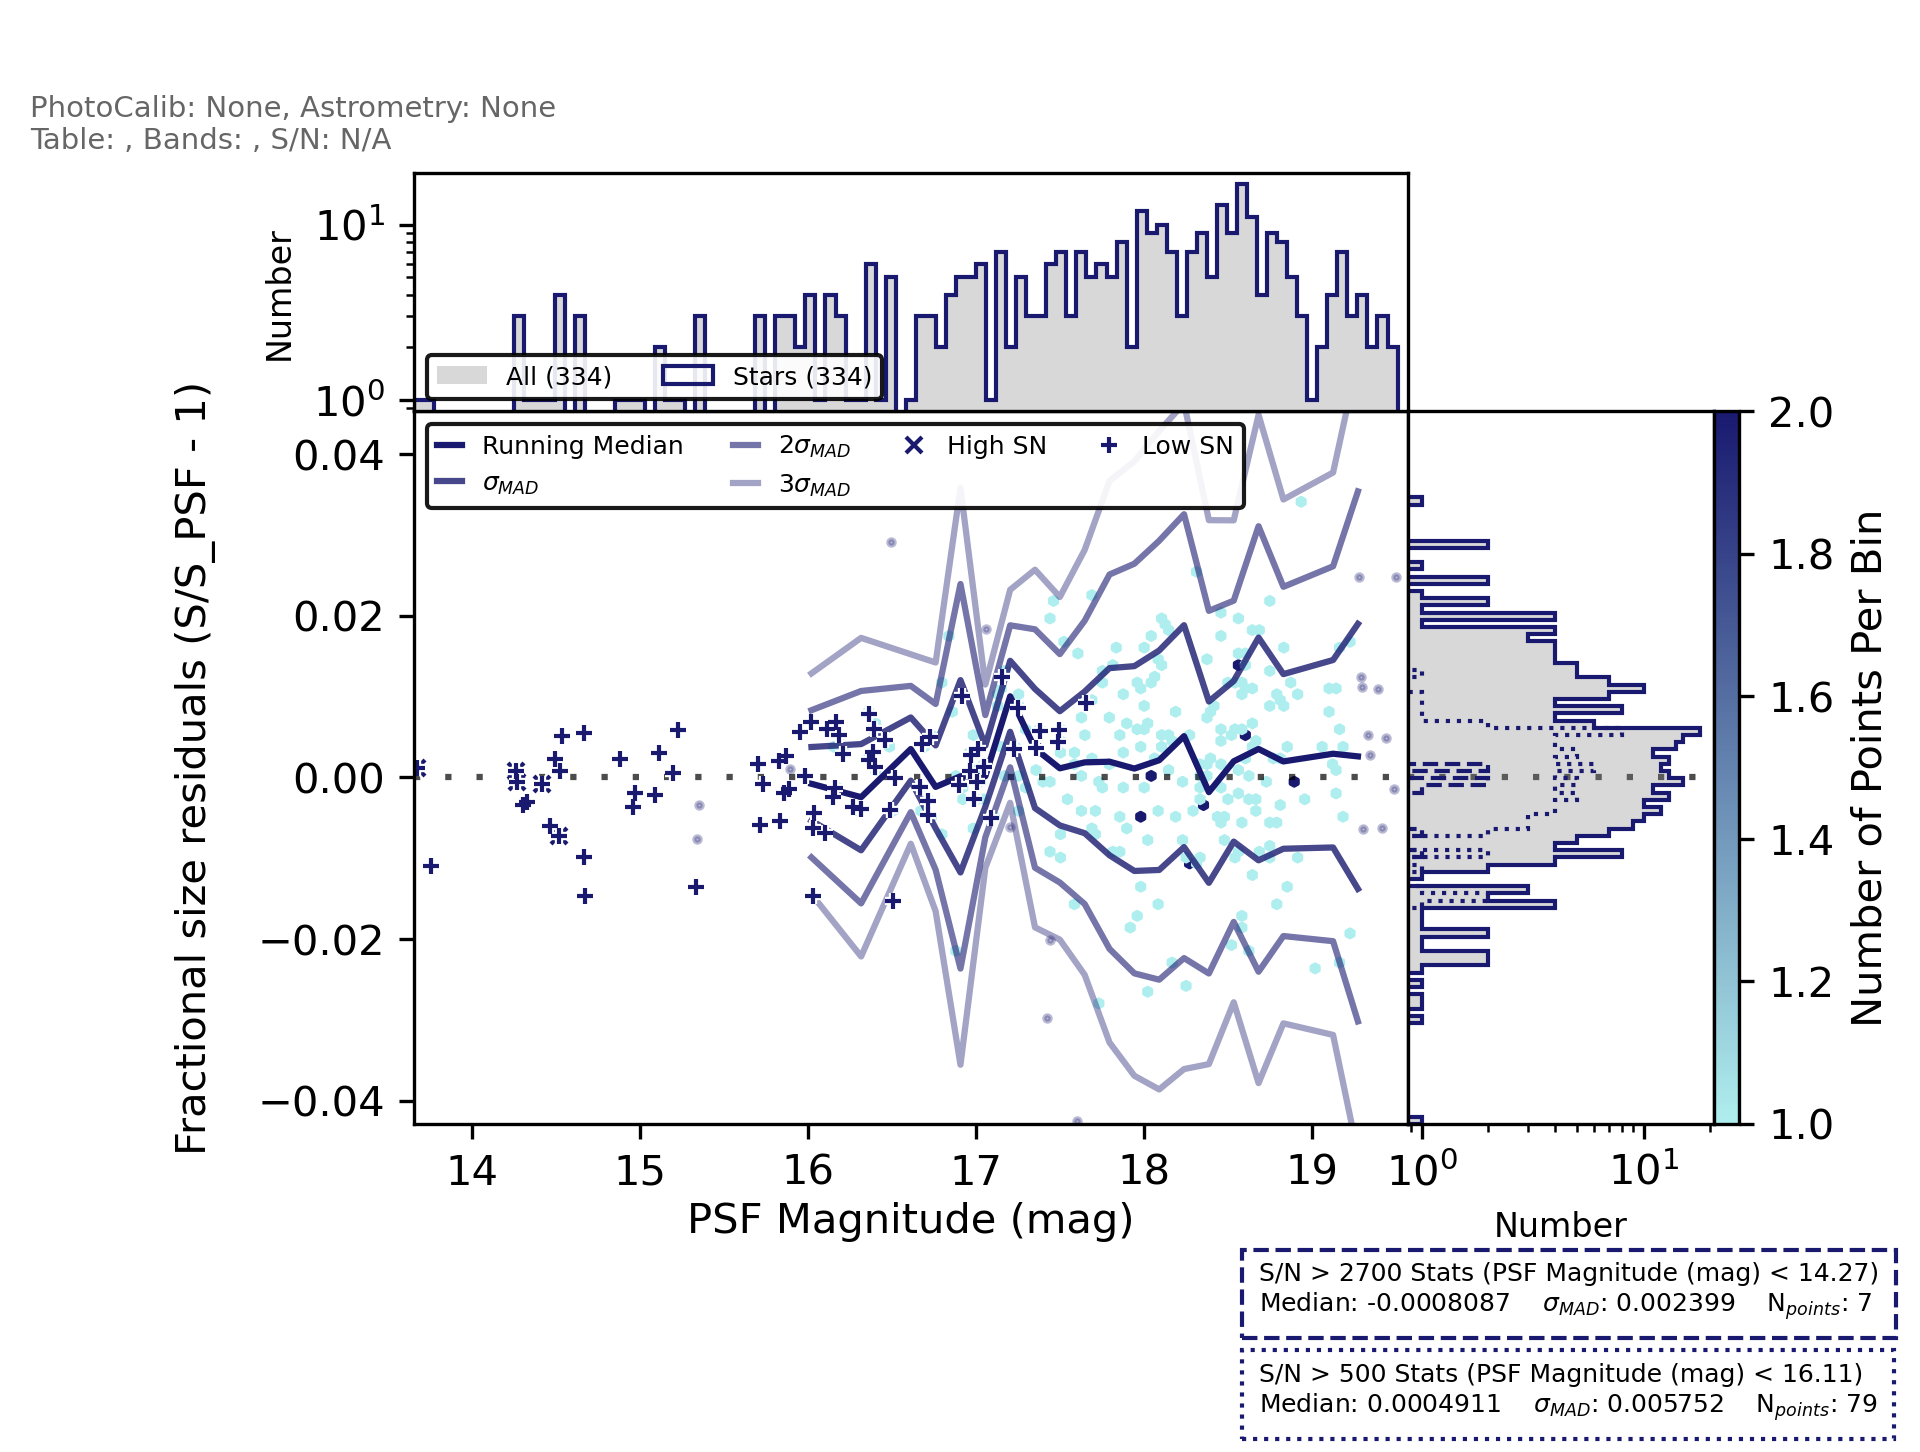

In [19]:
results = atool(objectTable, band='g', skymap=None, plotInfo=_StandinPlotInfo())
results

## ConfigurableActions are the atomic bits of `analysis_tools`

We introduce core concepts of the `analysis_tools` package, starting with the idea of [ConfigurableAction](https://pipelines.lsst.io/v/weekly/modules/lsst.pex.config/overview.html#specialized-config-subclasses)s, or actions for short.

### Terminology

Data Types (many of the [actions in analysis_tools](https://github.com/lsst/analysis_tools/tree/main/python/lsst/analysis/tools/actions) are grouped according to the resultant data type)
* `Scalar`: Something that is number like (int, float, numpy.float32 etc.)
* `Vector`: Something that is ndarray like
* `KeyedData`: Anything that is indexed by a string that can return a Vector, or Scalar

Analysis Structures
* `ConfigurableAction`: generic interface for function-like objects (actions) that have state which can be set during configuration
* `AnalysisAction`: A ConfigurableAction subclass that is specialized for actions that function in analysis contexts
* `AnalysisTool`: A top level "container" of multiple AnalysisActions which performs one type of analysis

We dive into the later two in more detail below

### Using AnalysisActions

- Configurable `AnalysisActions` are the atomic bits of `analysis_tools`. They can be combined together to make more complex actions, or used as part of an AnalysisTool
- We show some examples of using configurable actions like standalone functions to provide intution for how configurable actions work.
- Show examples with KeyedDataActions, VectorActions (including selectors), and ScalarActions
- Show examples of configuration

Let's use actions to compute the measured PSF size for a set of stars from an object catalog.

In [20]:
#from lsst.analysis.tools.actions.vector import CalcShapeSize
from lsst.analysis.tools.actions.vector import CalcMomentSize
from lsst.analysis.tools.actions.vector import ConvertFluxToMag

In [21]:
#sizeCalculator = CalcShapeSize()
sizeCalculator =  CalcMomentSize()

In [22]:
# Inspect the configuration of this object.
pprint(sizeCalculator.toDict())

{'colXx': '{band}_ixx',
 'colXy': '{band}_ixy',
 'colYy': '{band}_iyy',
 'sizeType': 'determinant'}


In [23]:
# Inspect the required input schema, notice that we will need to provide the band information
sizeCalculator.getInputSchema()

(('{band}_ixx', numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]),
 ('{band}_iyy', numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]),
 ('{band}_ixy', numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]))

In [24]:
size = sizeCalculator(objectTable, band='i')
print(size)

objectId
2229027828362379265     4.984384
2229027828362379266     4.764824
2229027828362379267     6.314911
2229027828362379268    13.526231
2229027828362379269     7.110947
                         ...    
2229092699548418677          NaN
2229092699548418678          NaN
2229092699548418679          NaN
2229092699548418680          NaN
2229092699548418681          NaN
Length: 14329, dtype: float64


In [25]:
magConverter = ConvertFluxToMag()

In [26]:
pprint(magConverter.toDict())

{'fluxUnit': 'nJy', 'returnMillimags': False, 'vectorKey': None}


In [27]:
magConverter.getInputSchema()

((None, numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]),)

In the next example, we show how to configure an action

In [28]:
# Another example, this time to convert fluxes to magnitudes
magConverter = ConvertFluxToMag()
magConverter.vectorKey='{band}_psfFlux'
mag = magConverter(objectTable, band='i')

In [29]:
# Notice that the lines above is equiavalent to the following
magConverterAlternate = ConvertFluxToMag()
magConverterAlternate.vectorKey='i_psfFlux'
magAlternate = magConverterAlternate(objectTable)

# Confirm the results match
assert np.allclose(mag, magAlternate, equal_nan=True)

It is also possible set configuration of an action during initialization

In [30]:
magConverterAlternate = ConvertFluxToMag(vectorKey='{band}_psfFlux')

assert np.allclose(
    magConverter(objectTable, band='i'), 
    magConverterAlternate(objectTable, band='i'), 
    equal_nan=True
)

Now make a plot

Text(0, 0.5, 'size')

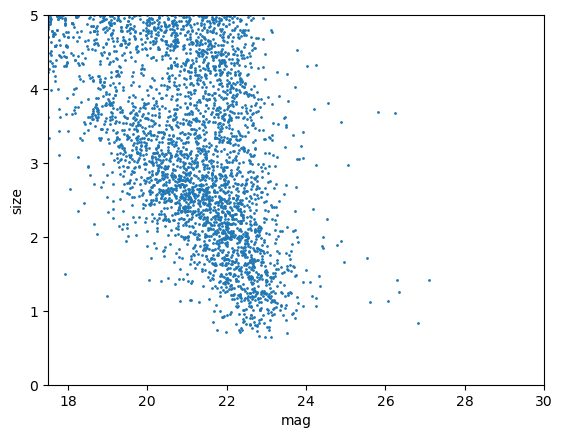

In [31]:
plt.figure()
plt.scatter(mag, size, s=1)
plt.xlim(17.5, 30.)
plt.ylim(0, 5)
plt.xlabel('mag')
plt.ylabel('size')

Let's remake that simple plot now selecting only the stars

In [32]:
from lsst.analysis.tools.actions.vector import StarSelector

In [33]:
StarSelector().toDict()

{'vectorKey': '{band}_extendedness', 'extendedness_maximum': 0.5}

In [34]:
StarSelector().getInputSchema()

(('{band}_extendedness', numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]),)

In [35]:
starSelection = StarSelector()(objectTable, band='i')

Text(0, 0.5, 'size')

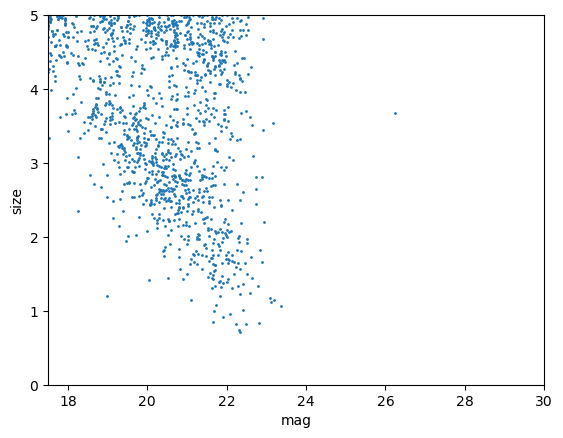

In [36]:
plt.figure()
plt.scatter(mag[starSelection], size.values[starSelection], s=1)
plt.xlim(17.5, 30.)
plt.ylim(0, 5)
plt.xlabel('mag')
plt.ylabel('size')

We can chain together `AnalysisAction`s, as in the following example that produces an equivalent plot. The `analysis_tools` package frequently uses this approach of chaining together `AnalysisAction`s.

In [37]:
from lsst.analysis.tools.actions.vector import DownselectVector
from lsst.analysis.tools.actions.keyedData import AddComputedVector

In [38]:
DownselectVector().toDict()

{'vectorKey': None, 'selector': {'vectorKey': None}}

In [39]:
DownselectVector().getInputSchema()

<generator object DownselectVector.getInputSchema at 0x7f9466a5f440>

In [40]:
AddComputedVector().toDict()

{'action': {}, 'keyName': None}

In [41]:
AddComputedVector().getInputSchema()

<generator object AddComputedVector.getInputSchema at 0x7f94653d87c0>

Text(0, 0.5, 'size')

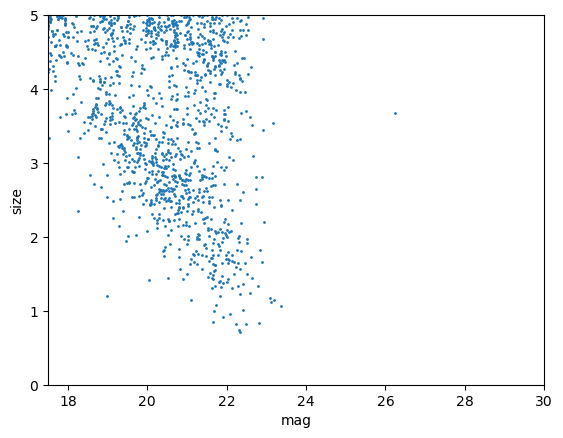

In [42]:
from lsst.analysis.tools.actions.vector import DownselectVector
from lsst.analysis.tools.actions.keyedData import AddComputedVector

band = "i"

# Add a new key that points to a vector of "size" values
objectTableDemo = AddComputedVector(action=CalcMomentSize, keyName="size")(objectTable, band=band)

# Note type(objectTable) is now a python dictionary instead of a pandas table, but since both
# "quack" like KeyedData they can be used interchangably

# Add a new key that points to a vector of "mag" values
objectTableDemo = AddComputedVector(
    action=ConvertFluxToMag(
        vectorKey='{band}_psfFlux'
    ),
    keyName="mag"
)(objectTableDemo, band=band)

# Example of a more explicit syntax
downselector = DownselectVector()
downselector.vectorKey = "size"
downselector.selector = StarSelector
size = downselector(objectTableDemo, band=band)

# Example of a more compact syntax
mag = DownselectVector(vectorKey="mag", selector=StarSelector)(objectTableDemo, band=band)

plt.figure()
plt.scatter(mag, size, s=1)
plt.xlim(17.5, 30.)
plt.ylim(0, 5)
plt.xlabel('mag')
plt.ylabel('size')

### Actions as a generic interface for data
Actions are not restricted to tables or products loaded from the butler, `KeyedData` could also be things like dictionaries of numpy arrays.

In [43]:
import lsst.analysis.tools.actions
dir(lsst.analysis.tools.actions)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'keyedData',
 'plot',
 'scalar',
 'vector']

In [44]:
from lsst.analysis.tools.actions.scalar import StdevAction

# create some KeyedData
data = {"randomData": np.random.normal(0, 3, 10000)}

# initialize an action, setting it to use the key set above
action = StdevAction(vectorKey="randomData")

#plt.figure()
#plt.hist(data["randomData"], bins=100, density=True)

# Run the action and print the results
print(f"The standard deviation is {action(data)}")

The standard deviation is 3.0140543752721443


### Create a new action

In the example below, we define a new VectorAction to multiply a vector by a scalar.

In [45]:
from lsst.analysis.tools.interfaces import VectorAction, KeyedData, KeyedDataSchema, Vector
from lsst.pex.config import Field
#rom lsstinterfaces import KeyedData, KeyedDataSchema

class MultiplyByScalar(VectorAction):
    """Multiply vector by a scalar value"""

    vectorKey = Field[str](doc="Key of vector which should be loaded")
    factor = Field[float](doc="Multiplicative factor", default=1.)

    def getInputSchema(self) -> KeyedDataSchema:
        return ((self.vectorKey, Vector),)

    def __call__(self, data: KeyedData, **kwargs) -> Vector:
        return np.array(self.factor * data[self.vectorKey.format(**kwargs)])

In [46]:
action = MultiplyByScalar(vectorKey="randomData", factor=2.)
results = action(data)
assert np.allclose(results, 2. * data['randomData'])

### Three conceptual steps in an `AnalysisTool`: prep, process, produce

As mentioned AnalysisTools can be thought of as executable containers of AnalysisActions. There are three different AnalysisActions, referred to as stages, named prep, process, and produce.
* Prep: Responsible for any initial selection and filtering of data
* Process: This is where any transformations and/or calculations are made
* Produce: Generates final plot and/or metric objects

The following examples will:
* Walk through the three stages of running an analysis tool in sequential lines of code, passing the output of one step as input to the next step
* Examine intermediate results

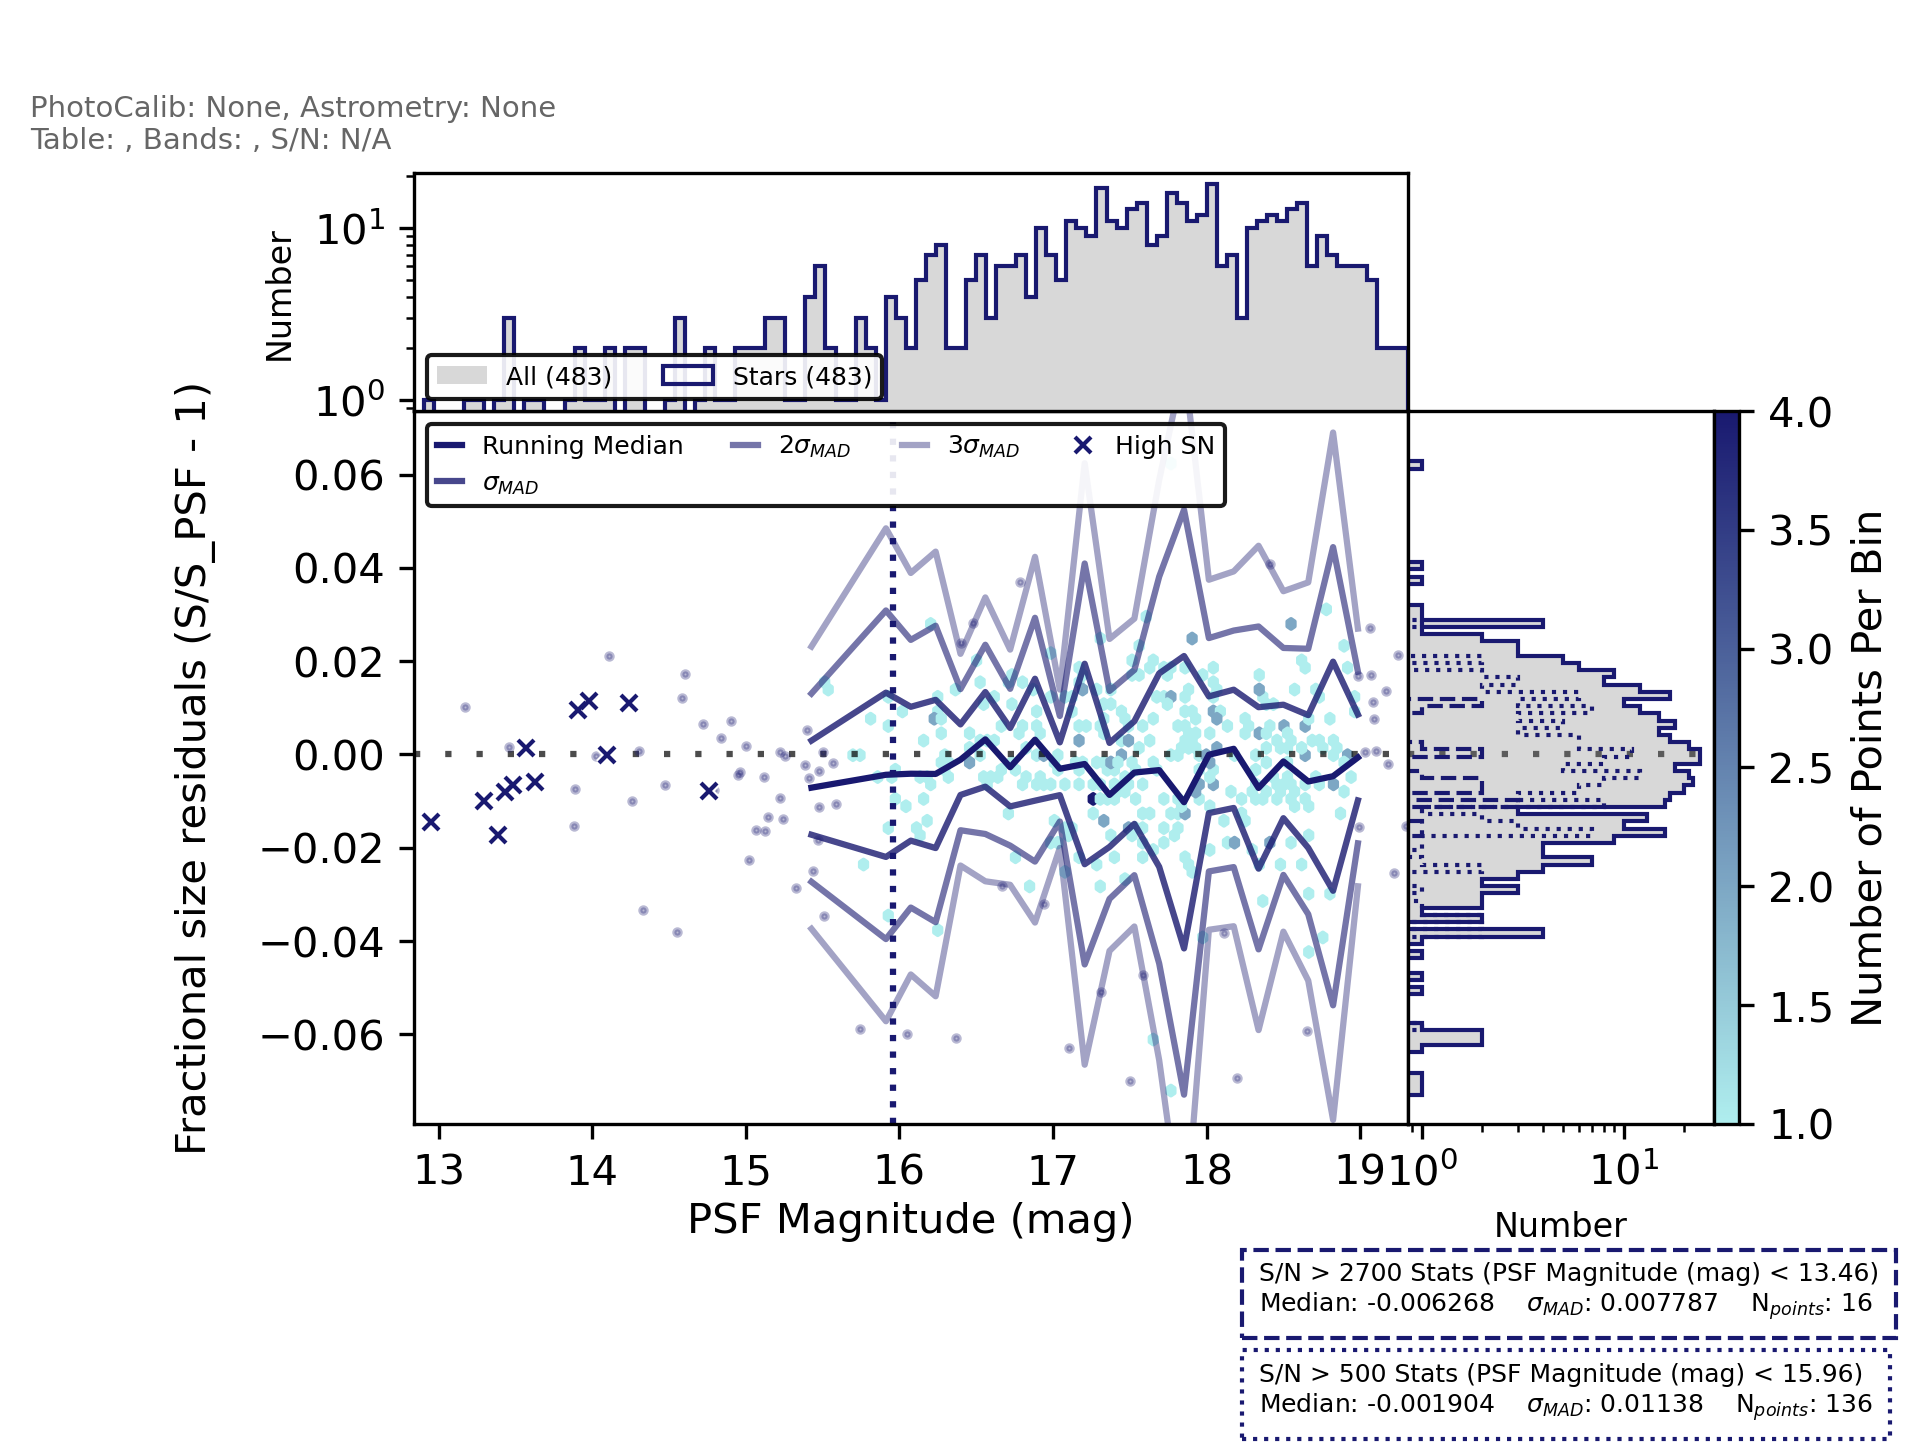

In [47]:
prepResults = atool.prep(objectTable, band='i')
processResults = atool.process(prepResults, band='i')
produceResults = atool.produce(processResults, band='i', skymap=None, plotInfo=_StandinPlotInfo())

Inspect the intermediate results

In [48]:
prepResults

{'patch': objectId
 2229027828362379273    274
 2229027828362379300    274
 2229027828362379306    274
 2229027828362379348    274
 2229027828362379357    274
                       ... 
 2229091600036791245    332
 2229092699548418129    333
 2229092699548418136    333
 2229092699548418554    333
 2229092699548418635    333
 Name: patch, Length: 573, dtype: int64,
 'i_psfFlux': objectId
 2229027828362379273    8.088464e+05
 2229027828362379300    7.006434e+05
 2229027828362379306    1.557268e+06
 2229027828362379348    1.987127e+05
 2229027828362379357    1.464877e+05
                            ...     
 2229091600036791245    3.458505e+05
 2229092699548418129    4.520573e+05
 2229092699548418136    7.060842e+05
 2229092699548418554    6.670129e+05
 2229092699548418635    4.954076e+05
 Name: i_psfFlux, Length: 573, dtype: float64,
 'i_ixx': objectId
 2229027828362379273    34.079858
 2229027828362379300    25.740248
 2229027828362379306    26.975119
 2229027828362379348    29.038435


In [49]:
processResults

{'patchWhole': array([274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274,
        275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275,
        275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276,
        276, 276, 276, 276, 276, 276, 276, 293, 293, 293, 293, 293, 293,
        293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293,
        293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293,
        293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293,
        293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293,
        293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294,
        294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294,
        294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294,
        294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294,
        294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294,
        294, 294, 294, 294, 294, 294,

## Workflow examples

### Running analysis_tools as part of a pipeline

* **All examples in this notebook should use the simple pipeline executor** (here is how you do it in a notebook)
* We have a PipelineTask for each data product. A task can run multiple AnalysisTools that each produce a set of plots or set of metrics and are subclasses of AnalysisPipelineTask.
* Discuss an example yaml pipeline file (load the yaml)
* Provide the command to run the pipeline
* Show how to configure the pipeline, e.g., turning on or off different metrics and plots or changing other parameters

**WARNING:** If you are using your own processed instance of rc_subset, run the following cells to run analysis_tools as part of a pipeline from the notebook. If you are pointing to a shared sandbox instance of rc2_subset, skip the remaining cells in this section.

In [50]:
if not SANDBOX_REPO:
    from lsst.ctrl.mpexec import SimplePipelineExecutor
    from lsst.pipe.base import Pipeline

    # set up an output collection with your username
    analysisToolsCollection = "u/%s/analysisToolsExampleAuxtel"%os.environ['USER']
    print(analysisToolsCollection)

    # this can be skipped if you already have a read writable butler setup (above is read only)
    #butlerRW = SimplePipelineExecutor.prep_butler(repo, inputs=collections, output=analysisToolsCollection)
    butlerRW = butler
    # load in the pipeline to run
    pipeline = Pipeline.from_uri("$ANALYSIS_TOOLS_DIR/pipelines/coaddQualityCore.yaml")

    # override a configuration within a certain AnalysisTool
    configKey = "atools.shapeSizeFractionalDiff.prep.selectors.snSelector.threshold"
    pipeline.addConfigOverride("analyzeObjectTableCore", configKey, 400)

    # Run only the PSF size residual tool
    pipeline.addConfigOverride("analyzeObjectTableCore", "atools", None)
    pipeline.addConfigOverride("analyzeObjectTableCore", "atools.shapeSizeFractionalDiff", ShapeSizeFractionalDiff)

    # bands = ['g', 'r', 'i', 'z']
    bands = ['i']
    pipeline.addConfigOverride("analyzeObjectTableCore", "bands", bands)
    pipeline.addConfigOverride("catalogMatchTract", "bands", bands)
    pipeline.addConfigOverride("refCatObjectTract", "bands", bands)

    # restrict processing to the same dataId used above
    whereString = "tract = 5615 AND skymap = 'latiss_v1'"

u/dagoret/analysisToolsExampleAuxtel


Display the pipeline that is about to be run

In [51]:
if not SANDBOX_REPO:
    print(pipeline)

description: 'Tier1 plots and metrics to assess coadd quality

  '
tasks:
  analyzeObjectTableCore:
    class: lsst.analysis.tools.tasks.ObjectTableTractAnalysisTask
    config:
    - python: |
        from lsst.analysis.tools.atools import *
        from lsst.analysis.tools.contexts import *
      connections.outputName: objectTableCore
      atools.shapeSizeFractionalDiff: ShapeSizeFractionalDiff
      atools.e1Diff: E1Diff
      atools.e2Diff: E2Diff
      atools.skyFluxStatisticMetric: SkyFluxStatisticMetric
      atools.skyFluxStatisticMetric.applyContext: CoaddContext
      atools.parentDeblenderMetrics: ParentDeblenderMetrics
      atools.skippedDeblenderMetrics: SkippedDeblenderMetrics
      atools.blendMetrics: BlendMetrics
      atools.isolatedDeblenderMetrics: IsolatedDeblenderMetrics
      atools.wPerpPSFP: WPerpPSF
      atools.wPerpCModel: WPerpCModel
      atools.xPerpPSFP: XPerpPSF
      atools.xPerpCModel: XPerpCModel
      atools.yPerpPSF: YPerpPSF
      atools.yPerpC

In [52]:
if not SANDBOX_REPO:
    # Prevent the executor from dumping plots into the notebook
    backend_ =  mpl.get_backend() 
    mpl.use("Agg")

    executor = SimplePipelineExecutor.from_pipeline(pipeline, where=whereString, butler=butlerRW)
    quanta = executor.run(True)

    # Restore the ability for plots to be put into the notebook
    mpl.use(backend_)

ValueError: Configuration validation failed for task 'photometricCatalogMatch' (see chained exception).

In [ ]:
if not SANDBOX_REPO:
    # Refresh our read-only butler to see the changes made. (It's generally a
    # good idea to work on read-only things)
    butler.registry.refresh()

## Access persisted metrics

Specify the collection that holds the results of running analysis_tools. If you are pointing to your own instance of rc2_subset, you did this already above prior to running the pipeline and the cell below is not needed.

In [ ]:
if SANDBOX_REPO:
    # The following is not needed if you are pointing to your own instance of rc2_subset
    analysisToolsCollection = "u/bechtol/analysisToolsExample"

Check what dataset types exist in the new collection.

In [ ]:
# See what datasets exist; there should now be objectTableCore_metrics
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=analysisToolsCollection).any(execute=False, exact=False):
        print(datasetType)

Access the persisted metrics.

In [ ]:
# Get the metric that was written
print(analysisToolsCollection)
refs = sorted(butler.registry.queryDatasets("objectTableCore_metrics", collections=analysisToolsCollection))
pprint(refs)
dataId = refs[-1].dataId
print(dataId)
print(refs[-1].run)
objectTable_metrics = butler.get("objectTableCore_metrics", dataId=dataId, collections=analysisToolsCollection)
pprint(objectTable_metrics)

Also, we can see that a plot has been persisted, but there isn't a way to visualize the plot from the notebook. In the next section, we'll use the `reconstructor` to recreate the plot in the notebook.

In [ ]:
refs = sorted(butler.registry.queryDatasets(
    "objectTableCore_i_shapeSizeFractionalDiff_ScatterPlotWithTwoHists", 
    collections=analysisToolsCollection)
)
print(refs[0])

# The following line will throw an error
# plot = butler.get(
#     "objectTableCore_i_shapeSizeFractionalDiff_ScatterPlotWithTwoHists",
#     dataId=refs[0].dataId,
#     collections=analysisToolsCollection
# )

### Reconstruct the inputs to an `AnalysisTool`

Analysis(Tools/Actions) allow the exact state of `AnalysisTool`s to be saved into the Butler when a pipeline is run. This allows a user to 'reconstruct' things as they were when the tools were executed. This aids in debugging and deep diving into the data.

Below is an example of reconstructing one of the tasks that was run in the Pipeline above.

In [ ]:
from lsst.analysis.tools.tasks.reconstructor import reconstructAnalysisTools

# Read in just one task
label = "analyzeObjectTableCore"
taskState, inputData = reconstructAnalysisTools(butler, 
                                                collection=analysisToolsCollection, 
                                                label=label, 
                                                dataId=dataId, 
                                                callback=None
)

We have access to the exact configuration that was used to run the analysis tools.

In [ ]:
pprint(taskState.toDict())

We also have access to the input data that were used to produce the diagnostics, in this case, the object table.

In [ ]:
inputData["data"]

Quick check to verify that the object table data are indeed the same.

In [ ]:
assert np.allclose(inputData["data"]['coord_ra'], objectTable['coord_ra'])

We can now reproduce diagnostic metrics and plots interactively in the notebook

In [ ]:
# The following configuration won't be needed in the future
taskState.atools.shapeSizeFractionalDiff.produce.plot.addSummaryPlot = False

taskState.atools.shapeSizeFractionalDiff(
    inputData['data'],
    band='i',
    skymap=None,
    plotInfo=_StandinPlotInfo()
)

Next, we change one of the configuration parameters to see how the results change. 

In this example, we raise the signal-to-noise threshold to 200. Notice that the metric values and plot change with this updated object selection criteria.

In [ ]:
# change some configuration to see the differences
taskState.atools.shapeSizeFractionalDiff.prep.selectors.snSelector.threshold = 200
taskState.atools.shapeSizeFractionalDiff(
    inputData['data'],
    band='i',
    skymap=None,
    plotInfo=_StandinPlotInfo()
)

As before, we can also step through the calculation to check intermediate steps.

In [ ]:
prepResults = taskState.atools.shapeSizeFractionalDiff.prep(objectTable, band='i')
processResults = taskState.atools.shapeSizeFractionalDiff.process(prepResults, band='i')
produceResults = taskState.atools.shapeSizeFractionalDiff.produce(processResults, band='i', skymap=None, plotInfo=_StandinPlotInfo())

## Create a new analysis tool

Example `AnalysisTool`s can be found in the [atools](https://github.com/lsst/analysis_tools/tree/main/python/lsst/analysis/tools/atools) directory of the package.

Now let's create our own `AnalysisTool`

In [ ]:
from lsst.analysis.tools.interfaces import AnalysisTool
from lsst.analysis.tools.actions.scalar import MedianAction, CountAction
from lsst.analysis.tools.actions.vector import SnSelector


class DemoTool(AnalysisTool):
    #parameterizedBand: bool = False
    
    def setDefaults(self):
        super().setDefaults()
        
        # select on high signal to noise obejcts
        # add in a signal to noise selector
        self.prep.selectors.snSelector = SnSelector()
        
        # set what key the selector should use when deciding SNR
        self.prep.selectors.snSelector.fluxType = "psfFlux"
        
        # select what threshold value is desireable for the selector
        self.prep.selectors.snSelector.threshold = 10
        
        # the final name in the qualification is used as a key to insert
        # the calculation into KeyedData
        self.process.calculateActions.median = MedianAction()
        self.process.calculateActions.median.vectorKey = "psfFlux"
        self.process.calculateActions.count = CountAction()
        self.process.calculateActions.count.vectorKey = "psfFlux"
        
        # tell the metic what the units are for the quantity
        self.produce.metric.units = {"median": "Jy",
                                     "count": "count"}
        
        # Rename the quanity prior to producing the Metric
        # (useful for resuable workflows that set a name toward the end of computation)
        # self.produce.metric.newNames = {"medianValueName": "DemoMetric"}

Examine the configuration of our new tool

In [ ]:
DemoTool().toDict()

Make some synthetic data

In [ ]:
# Make some synthetic data
size = 500
flux = np.logspace(1., 4., size)
fluxErr = np.sqrt(flux)
flux += np.random.normal(0, np.sqrt(flux), size)
data = {"psfFlux": flux, "psfFluxErr": fluxErr}

plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.scatter(data['psfFlux'], data['psfFluxErr'])
plt.xlabel('psfFlux')
plt.ylabel('psfFluxErr')

Run the new analysis tool.

In [ ]:
demoTool = DemoTool()
demoTool.populatePrepFromProcess()

# We can configure as needed
demoTool.prep.selectors.snSelector.threshold = 50

demoTool(data)

We can inspect intermediate stages of the analysis.

In [ ]:
# Example: how many of the data points pass the SNR threshold?
len(demoTool.prep(data)['psfFlux'])